In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [48]:
df = pd.read_csv("merged_preprocessed_crop_yield.csv")

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (54804, 20)


,Year,Decade,State Name,State_encoded,Dist Name,Crop,Crop_encoded,Season,Season_encoded,Area_ha,N_req_kg_per_ha,P_req_kg_per_ha,K_req_kg_per_ha,Temperature_C,Humidity_%,pH,Rainfall_mm,Wind_Speed_m_s,Solar_Radiation_MJ_m2_day,Yield_kg_per_ha
0,1966,1960,chhattisgarh,3,durg,rice,3,Unknown,4,548000.0,8.43975,4.05108,7.42698,25,80,6.5,1200,2.0,18,337.59
1,1966,1960,chhattisgarh,3,durg,maize,2,Unknown,4,3000.0,18.00009,8.00004,11.33339,22,70,6.0,800,2.5,20,666.67
2,1966,1960,chhattisgarh,3,durg,chickpea,0,Unknown,4,54000.0,9.00000,5.00000,9.00000,20,60,6.5,600,1.5,16,500.00
3,1967,1960,chhattisgarh,3,durg,rice,3,Unknown,4,547000.0,18.69275,8.97252,16.44962,25,80,6.5,1200,2.0,18,747.71
4,1967,1960,chhattisgarh,3,durg,maize,2,Unknown,4,3000.0,27.00000,12.00000,17.00000,22,70,6.0,800,2.5,20,1000.00


In [ ]:
num_cols = df.select_dtypes(include=['int64','float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].median())

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
    df[col] = df[col].fillna(df[col].mode()[0])

In [ ]:
X = df.drop(columns=['Yield_kg_per_ha'])
y = df['Yield_kg_per_ha']

In [29]:
X = X.drop(columns=['State Name', 'Dist Name', 'Crop', 'Season'])

In [49]:
scaler = StandardScaler()

num_cols = X.select_dtypes(include=['int64','float64']).columns
X[num_cols] = scaler.fit_transform(X[num_cols])

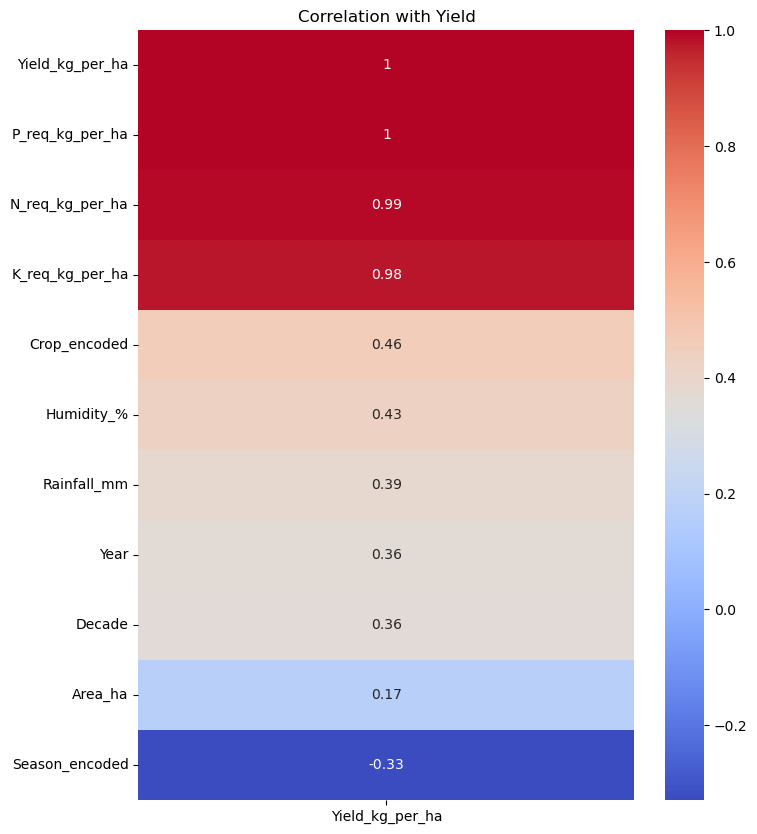

In [51]:
corr = pd.concat([X, y], axis=1).corr()

plt.figure(figsize=(8,10))
sns.heatmap(
    corr[['Yield_kg_per_ha']]
    .sort_values(by='Yield_kg_per_ha', ascending=False),
    annot=True,
    cmap='coolwarm'
)
plt.title("Correlation with Yield")
plt.show()

In [32]:
corr_threshold = 0.10
selected_features = corr['Yield_kg_per_ha'].abs()
selected_features = selected_features[selected_features > corr_threshold].index
selected_features = selected_features.drop('Yield_kg_per_ha')

X = X[selected_features]
X.shape

(54804, 10)

In [56]:
lr_temp = LinearRegression()
rfe = RFE(lr_temp, n_features_to_select=10)
rfe.fit(X, y)

rfe_features = X.columns[rfe.support_]
print("Selected Features:", list(rfe_features))

X = X[rfe_features]

Selected Features: ['Year', 'Decade', 'Crop_encoded', 'Season_encoded', 'Area_ha', 'N_req_kg_per_ha', 'P_req_kg_per_ha', 'K_req_kg_per_ha', 'Humidity_%', 'Rainfall_mm']


In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

Train Shape: (38362, 10)
Test Shape: (16442, 10)


In [58]:
start = time.time()

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_time = time.time() - start
lr_preds = lr_model.predict(X_test)

In [59]:
start = time.time()

rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

rf_time = time.time() - start
rf_preds = rf_model.predict(X_test)

In [60]:
start = time.time()

gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

gb_model.fit(X_train, y_train)

gb_time = time.time() - start
gb_preds = gb_model.predict(X_test)

In [62]:
from xgboost import XGBRegressor

start = time.time()

xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

xgb_time = time.time() - start
xgb_preds = xgb_model.predict(X_test)

In [65]:
def evaluate(name, y_true, y_pred, train_time):
    return {
        "Model": name,
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R²": r2_score(y_true, y_pred),
        "Training Time (sec)": train_time
    }

results = pd.DataFrame([
    evaluate("Linear Regression", y_test, lr_preds, lr_time),
    evaluate("Random Forest", y_test, rf_preds, rf_time),
    evaluate("Gradient Boosting", y_test, gb_preds, gb_time),
    evaluate("XGBoost", y_test, xgb_preds, xgb_time)
])

results = results.sort_values(by="RMSE")
results


,Model,RMSE,MAE,R²,Training Time (sec)
2,Gradient Boosting,2.989669,2.074983,0.999991,17.526762
1,Random Forest,9.451137,0.355850,0.999912,4.472033
0,Linear Regression,14.494397,9.326989,0.999793,0.009128
3,XGBoost,47.765135,6.261966,0.997751,0.416607


In [41]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, lr_preds)),
        np.sqrt(mean_squared_error(y_test, rf_preds)),
        np.sqrt(mean_squared_error(y_test, xgb_preds))
    ],
    "MAE": [
        mean_absolute_error(y_test, lr_preds),
        mean_absolute_error(y_test, rf_preds),
        mean_absolute_error(y_test, xgb_preds)
    ],
    "R² Score": [
        r2_score(y_test, lr_preds),
        r2_score(y_test, rf_preds),
        r2_score(y_test, xgb_preds)
    ]
})

results.style\
    .background_gradient(cmap="viridis", subset=["R² Score"])\
    .background_gradient(cmap="coolwarm_r", subset=["RMSE", "MAE"])\
    .format({"RMSE": "{:.2f}", "MAE": "{:.2f}", "R² Score": "{:.3f}"})

,Model,RMSE,MAE,R² Score
0,Linear Regression,14.40,9.41,1.000
1,Random Forest,12.06,0.52,1.000
2,XGBoost,63.69,7.34,0.996


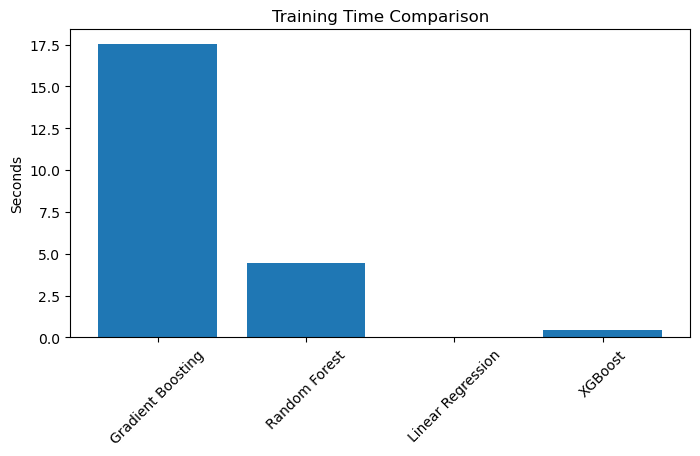

In [66]:
plt.figure(figsize=(8,4))
plt.bar(results["Model"], results["Training Time (sec)"])
plt.title("Training Time Comparison")
plt.ylabel("Seconds")
plt.xticks(rotation=45)
plt.show()

In [67]:
best_model = results.iloc[0]
print("🏆 Best Model")
print(best_model)

🏆 Best Model
Model                  Gradient Boosting
RMSE                            2.989669
MAE                             2.074983
R²                              0.999991
Training Time (sec)            17.526762
Name: 2, dtype: object


In [ ]:
# joblib.dump(lr_model, "linear_regression_model.pkl")
# joblib.dump(rf_model, "random_forest_model.pkl")
# joblib.dump(gb_model, "gradient_boosting_model.pkl")
# joblib.dump(xgb_model, "xgboost_model.pkl")

# print("✅ All models saved successfully.")

In [68]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

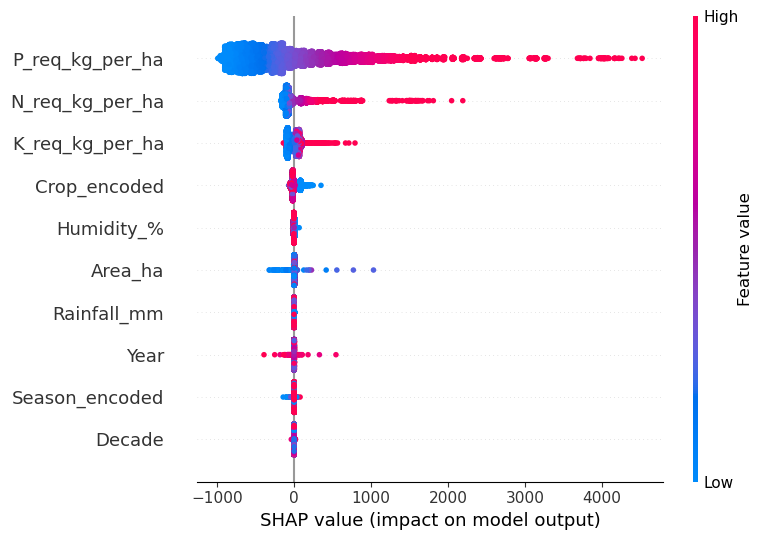

In [69]:
shap.summary_plot(shap_values, X_test)

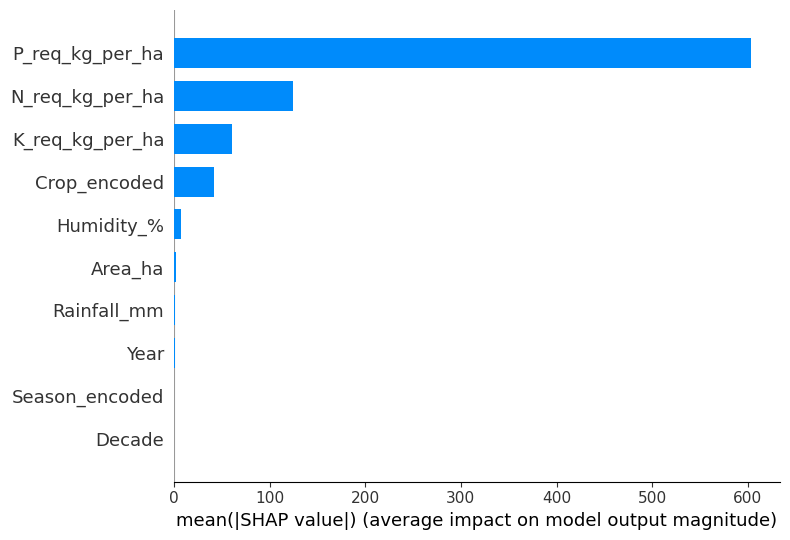

In [70]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

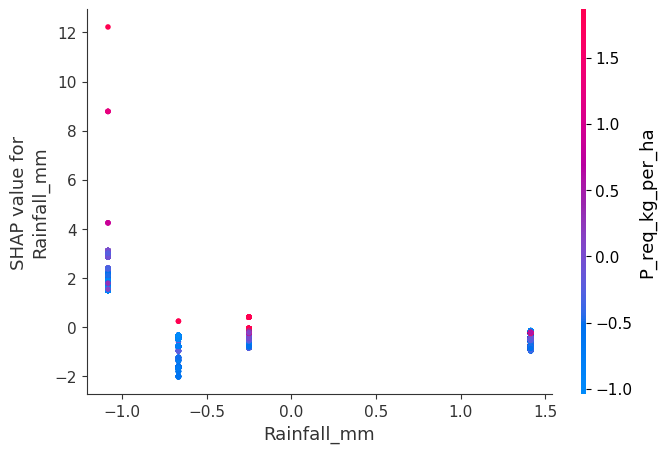

In [71]:
shap.dependence_plot("Rainfall_mm", shap_values, X_test)

['xgb_crop_yield_model.joblib']

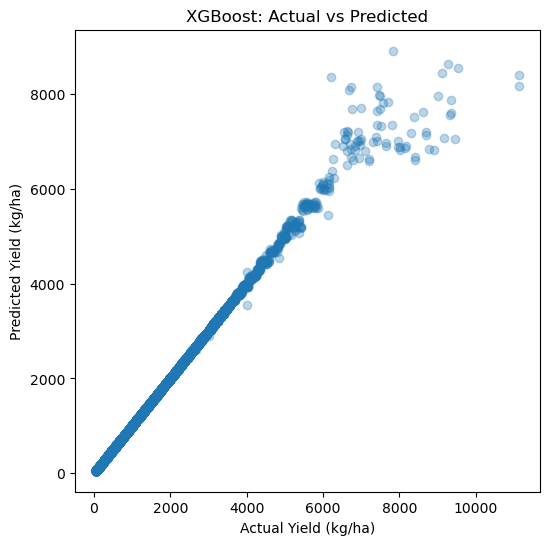

In [46]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, xgb_preds, alpha=0.3)
plt.xlabel("Actual Yield (kg/ha)")
plt.ylabel("Predicted Yield (kg/ha)")
plt.title("XGBoost: Actual vs Predicted")
plt.show()